# Вариационные автокодировщики

## Постановка задачи
Дана выборка независимых одинаково распределенных величин из истинного распределения $x_i \sim p_d(x)$, $i = 1, \dots, N$.

Задача - построить вероятностную модель $p_\theta(x)$ истинного распределения $p_d(x)$.

Распределение $p_\theta(x)$ должно позволять как оценить плотность вероятности для данного объекта $x$, так и сэмплировать $x \sim p_\theta(x)$.

## Вероятностная модель
$z \in \mathbb{R}^d$ - локальная латентная переменная, т. е. своя для каждого объекта $x$.

Генеративный процесс вариационного автокодировщика:
1. Сэмплируем $z \sim p(z)$.
2. Сэмплируем $x \sim p_\theta(x | z)$.

Параметры распределения $p_\theta(x | z)$ задаются нейросетью с весами $\theta$, получающей на вход вектор $z$.

Индуцированная генеративным процессом плотность вероятности объекта $x$:

$$p_\theta(x) = \mathbb{E}_{z \sim p(z)} p_\theta(x | z)$$

Эта плотность может быть оценена с помощью метода Монте-Карло:

$$z_i \sim p(z), i = 1, \dots, K$$
$$p_\theta(x) \approx \frac{1}{K} \sum\limits_{i = 1}^K p_\theta(x | z_i)$$

### Параметризация модели
Априорное распределение на скрытые перменные - стандартное нормальное распределение: $p(z) = \mathcal{N}(z | 0, I)$.

Распределения на компоненты $x$ условно независимы относительно $z$: $p_\theta(x | z) = \prod\limits_{i = 1}^D p_\theta(x_i | z)$.

Если i-ый признак объекта вещественный, то $p_\theta(x_i | z) = \mathcal{N}(x_i | \mu_i(z, \theta), \sigma^2_i(z, \theta))$.
Здесь $\mu(z, \theta)$ и $\sigma(z, \theta)$ - детерминированные функции, задаваемые нейросетями с параметрами $\theta$.

Если i-ый признак категориальный, то $p_\theta(x_i | z) = Cat(Softmax(\omega_i(z, \theta)))$, где $\omega_i(z, \theta)$ - тоже детерминированная функция задаваемая нейросетью.

## Обучение модели с использованием принципа максимального правдоподобия

Описанная модель может быть обучена с помощью максимизации правдоподобия модели методом стохастического градиентного спуска. Правдоподобие и его градиент не могут быть вычислены в явном виде, поэтому вместо них используем их оценки, полученные методом Монте-Карло:

$$\log p_\theta(x) =
\log \mathbb{E}_{z \sim p(z)} p_\theta(x | z)
\approx \log \frac{1}{K} \sum\limits_{i=1}^K p_\theta(x | z_i)$$
$$\log p_\theta(x) \to \max\limits_\theta$$
$$\frac{\partial \log p_\theta(x)}{\partial \theta} =
\frac{\partial}{\partial \theta} \log \mathbb{E}_{z \sim p(z)} p_\theta(x | z)
\approx \frac{\partial}{\partial \theta} \log \frac{1}{K} \sum\limits_{i=1}^K p_\theta(x | z_i)$$

Кстати, докажите несмещенность оценки на градиент.

Ваше доказательство здесь.

~

### Загрузка, нормировка и визуалиация данных

In [2]:
from torchvision.datasets import MNIST, FashionMNIST
from torch.utils.data import TensorDataset, DataLoader
import torch
from torch import nn
from torch import optim
from torch.autograd import Variable

In [3]:
data = MNIST('mnist', download=True, train=True)
train_data = TensorDataset(data.train_data.view(-1, 28 * 28).float() / 255, data.train_labels)
data = MNIST('mnist', download=True, train=False)
test_data = TensorDataset(data.test_data.view(-1, 28 * 28).float() / 255, data.test_labels)

Processing...
Done!


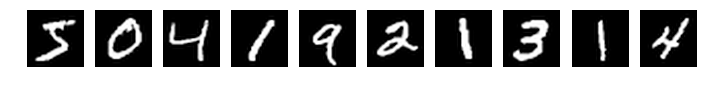

In [4]:
from matplotlib import pyplot as plt
%matplotlib inline

def show_images(x):
    plt.figure(figsize=(12, 12 / 10 * (x.shape[0] // 10 + 1)))
    x = x.view(-1, 28, 28)
    for i in range(x.shape[0]):
        plt.subplot(x.shape[0] // 10 + 1, 10, i + 1)
        plt.imshow(x.data[i].numpy(), cmap='Greys_r', vmin=0, vmax=1, interpolation='lanczos')
        plt.axis('off')

show_images(Variable(train_data[:10][0]))

### Функция потерь: кроссэнтропия

В качестве функции потерь используем бинарную кроссэнтропию.
Это означает, что мы предполагаем, что каждый пискель - бинарная случайная величина.
Генеративная сеть выдает вероятность каждого пикселя быть равным $1$.
Однако это означает, что для корректности вероятностной модели исходное изображение также должно быть бинаризовано.

Бинаризация может производиться как округлением данных в датасете, так и сэмплированием из распределения Бернулли каждого пикселя. Округление приводит к более гладким фигурам в обучающей выборке, поэтому будем использовать его.

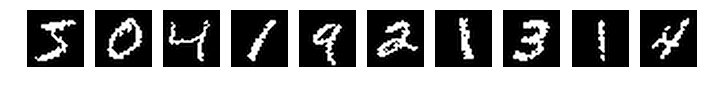

In [5]:
show_images(Variable(torch.bernoulli(train_data[:10][0])))

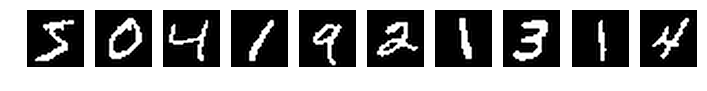

In [6]:
show_images(Variable(train_data[:10][0].round()))

In [7]:
train_data.data_tensor = train_data.data_tensor.round()
test_data.data_tensor = test_data.data_tensor.round()

In [29]:
import numpy as np

In [156]:
def binary_crossentropy_loss(x_true, x_distr):
    """
    Вычисляет бинарную кроссэнтропию между эмприческим распределением на данные
    и индуцированным моделью распределением, т. е. правдоподобие объектов x_true.
    Каждому объекту из x_true соответствуют K сэмплированных распределений
    на x из x_distr.
    i-му объекту соответствуют распределения с номерами i * K, ..., (i + 1) * K - 1.
    Требуется вычислить оценку логарифма правдоподобия для каждого объекта.
    Подсказка: не забывайте про вычислительную стабильность!

    Вход: x_true, Variable - матрица объектов размера n x D.
    Вход: x_distr, Variable - матрица параметров распределений Бернулли
    размера (n * K) x D.
    Выход: Variable, матрица размера n x K - оценки логарифма правдоподобия
    каждого сэмпла.
    """
    K = x_distr.shape[0] // x_true.shape[0]
    n, D = x_true.shape
    x = x_true.data.numpy()
    log_dist = np.log(x_distr.data.numpy().reshape(K, n, D))
    loss = np.einsum('knd, nd->nk', log_dist, x) + np.einsum('knd, nd->nk', 1 - log_dist, 1 - x)
    return Variable(torch.FloatTensor(loss))

In [169]:
def log_mean_exp(mtx):
    """
    Возвращает логарифм среднего по каждому столбцу от экспоненты данной матрицы.
    Подсказка: не забывайте про вычислительную стабильность!
    Вход: mtx, Varibale - матрица размера n x k.
    Возвращаемое значение: Variable, вектор длины n.
    """
    return torch.log(torch.mean(torch.exp(mtx), 1))

### Модель

In [186]:
from scipy.stats import norm
import random

In [189]:
class NaiveModel(nn.Module):
    def __init__(self, d, D):
        """
        Инициализирует веса модели.
        Вход: d, int - размерность латентного пространства.
        Вход: D, int - размерность пространства объектов.
        """
        super(type(self), self).__init__()
        self.d = d
        self.D = D
        self.generative_network = nn.ModuleList([
            nn.Linear(self.d, 200),
            nn.LeakyReLU(),
            nn.Linear(200, 200),
            nn.LeakyReLU(),
            nn.Linear(200, self.D),
            nn.Sigmoid()
        ])

    def sample_prior(self, num_samples):
        """
        Генерирует сэмплы из априорного распределения на z.
        Вход: num_samples, int - число сэмплов, которые надо сгененрировать.
        Возвращаемое значение: Variable, матрица размера num_samples x d.
        """
        samples = np.array([[random.random() for _ in range(self.d)] for _ in range(num_samples)])
        samples = norm.isf(samples, loc=0, scale=1)
        return Variable(torch.FloatTensor(samples))

    def generative_distr(self, z):
        """
        По матрице латентных представлений z возвращает матрицу параметров
        распределения Бернулли для сэмплирования объектов x.
        Вход: z, Variable - матрица n x d латентных представлений.
        Возвращаемое значение: Variable, матрица параметров распределения
        Бернулли размера n x D.
        """
        for layer in self.generative_network:
            z = layer(z)
        return z
        

    def batch_loss(self, batch, K):
        """
        Вычисляет оценку логарифма правдоподобия по батчу используя K сэмплов
        для каждого объекта.
        Вход: batch, Variable - матрица объектоа размера n x D.
        Вход: K, int - число сэмплов для каждого объекта.
        Возвращаемое значение: Variable, скаляр - логарифм правдоподобия по батчу.
        """
        n = batch.shape[0]
        z  = self.sample_prior(n * K)
        x_distr = self.generative_distr(z)
        return torch.mean(binary_crossentropy_loss(batch, x_distr))

    def generate_samples(self, num_samples):
        """
        Генерирует сэмплы из индуцируемого моделью распределения на объекты x.
        Вход: num_samples, int - число сэмплов, которые надо сгененрировать.
        Возвращаемое значение: Variable, матрица размера num_samples x D.
        """
        z = self.sample_prior(num_samples)
        for layer in self.generative_network:
            z = layer(z)
        x_distr = self.generative_distr(z)
        return torch.bernoulli(x_distr)

In [190]:
def model_test_loss(compute_loss, batch_size=100, max_batches=None, verbose=False):
    """
    Функция вычисляет усредненное значение функции потерь по тестовым данным.
    Вход: compute_loss, функция, принимающая батч в виде матрицы torch.FloatTensor
    и возвращающая float - функцию потерь на батче.
    Вход: batch_size, int.
    Вход: max_batches, int - если задано, включает режим оценки функции потерь
    с помощью сэмплирования батчей вместо полного прохода по данным и указывает,
    после какого батча прекратить вычисления.
    Вход: verbose, bool - указывает, печатать ли текущее состояние в процессе работы.
    Возвращаемое значение: float - оценка функции потерь на тестовых данных.
    """
    dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=(max_batches is None))
    num_batches = len(dataloader)
    avg_loss = 0
    for i, (batch, _) in enumerate(dataloader):
        loss = compute_loss(batch)
        avg_loss += (loss - avg_loss) / (i + 1)
        if verbose and (i + 1) % 10 == 0:
            print('\rTest loss:', avg_loss,
                  'Batch', i + 1, 'of', num_batches, ' ' * 10, end='', flush=True)
        if verbose and (i + 1) % 100 == 0:
            print(flush=True)
        if max_batches and i >= max_batches:
            break
    return avg_loss

In [191]:
def compute_log_likelihood_monte_carlo(batch, model, K):
    """
    Функция, оценку логарифма правдоподобия вероятностной модели по батчу методом Монте-Карло.
    Вход: batch, FloatTensor - матрица размера n x D
    Вход: model, Module - объект, имеющий методы sample_prior и generative_distr, описанные в NaiveModel.
    Вход: K, int - количество сэмплов.
    Возвращаемое значение: float - оценка логарифма правдоподобия.
    """
    # ваш код здесь
    pass

def model_test_log_likelihood_monte_carlo(model, K=10, batch_size=100, max_batches=None, verbose=False):
    """
    Функция, вовращает оценку логарифма правдоподобия данной модели по тестовым данным.
    Вход: model, Module - объект, имеющий методы sample_prior и generative_distr, описанные в NaiveModel.
    Вход: K, int - количество сэмплов.
    Остальные входы описаны в функции model_test_loss.
    Возвращаемое значение: float - оценка логарифма правдоподобия.    
    """
    return model_test_loss(lambda batch: compute_log_likelihood_monte_carlo(batch, model, K),
                           batch_size=batch_size,
                           max_batches=max_batches,
                           verbose=verbose)

In [192]:
def train_model(model, tests=[], batch_size=100, K=1, num_epochs=3, learning_rate=1e-3):
    """
    Обучает модель.
    Вход: model, Module - объект, модель.
    У этого объекта должна быть функция batch_loss от batch - FloatTensor и K - int,
    возвращающая скаляр Variable - функцию потерь на батче, которая должна быть
    оптимизирована.
    Вход: tests - список тестов, выполняемых после каждого 100-го батча.
    Каждый элемент списка - словарь с полями 'name' - уникальным идентификатором
    теста и 'func' - функцией от модели.
    Вход: batch_size, int.
    Вход: K, int.
    Вход: num_epochs, int.
    Вход: learning_rate, float.
    Возвращаемое значение: словарь с полями 'model' - обученная модель,
    'train_losses_list' - список функций потерь на каждом батче и 
    'test_results' - список результатов тестирования. Каждый результат
    тестирования - словарь вида name: value, где name - имя теста,
    value - результат его выполнения.
    """
    gd = optim.Adam(model.parameters(), lr=learning_rate)
    dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    train_losses = []
    test_results = []
    for _ in range(num_epochs):
        for i, (batch, _) in enumerate(dataloader):
            total = len(dataloader)
            loss = model.batch_loss(batch, K)
            (-loss).backward()
            train_losses.append(loss.data.numpy()[0])
            if (i + 1) % 10 == 0:
                print('\rTrain loss:', train_losses[-1],
                      'Batch', i + 1, 'of', total, ' ' * 10, end='', flush=True)
            if (i + 1) % 100 == 0:
                cur_test_result = {}
                for test in tests:
                    cur_test_result[test['name']] = test['func'](model)
                test_results.append(cur_test_result)
                print(flush=True)
            gd.step()
            gd.zero_grad()
    return {
        'model': model,
        'train_losses_list': train_losses,
        'test_results': test_results
    }

In [193]:
naive_tests = [
    {
        'name': 'MC',
        'func': lambda model: model_test_log_likelihood_monte_carlo(model, max_batches=20)
    }
]

In [ ]:
naive_model_d2_k1 = train_model(NaiveModel(2, 784), tests=naive_tests, K=1)

In [ ]:
naive_model_d2_k10 = train_model(NaiveModel(2, 784), tests=naive_tests, d=2, K=10)

In [ ]:
naive_model_d10_k1 = train_model(NaiveModel(10, 784), tests=naive_tests, K=1)

In [ ]:
naive_model_d10_k10 = train_model(NaiveModel(10, 784), tests=naive_tests, K=10)

## Оценка качества модели

### Визуальная оценка генерируемых объектов

In [ ]:
show_images(naive_model_d2_k1['model'].generate_samples(10))

In [ ]:
show_images(naive_model_d2_k10['model'].generate_samples(10))

In [ ]:
show_images(naive_model_d10_k1['model'].generate_samples(10))

In [ ]:
show_images(naive_model_d10_k10['model'].generate_samples(10))

### Визуализация латентного пространства

In [ ]:
n = 15
digit_size = 28

from scipy.stats import norm
import numpy as np

grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

def draw_manifold(model):
    figure = np.zeros((digit_size * n, digit_size * n))
    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            z_sample = np.array([[xi, yi]])

            x_decoded = model.generative_distr(Variable(torch.from_numpy(z_sample).float())).view(28, 28).data.numpy()
            digit = x_decoded
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit
    plt.figure(figsize=(10, 10))
    plt.imshow(figure, cmap='Greys_r', vmin=0, vmax=1, interpolation='lanczos')
    plt.axis('off')
    plt.show()

In [ ]:
draw_manifold(naive_model_d2_k1['model'])

In [ ]:
draw_manifold(naive_model_d2_k10['model'])

### Оценка правдоподобия тестовых данных в обученной модели методом Монте-Карло

In [ ]:
for label, model in [
    ('$K = 1, d = 2$', naive_model_d2_k1),
    ('$K = 10, d = 2$', naive_model_d2_k10),
    ('$K = 1, d = 10$', naive_model_d10_k1),
    ('$K = 10, d = 10$', naive_model_d10_k10)
]:
    data = [x['MC'] for x in model['test_results']]
    x_labels = (1 + np.arange(len(data))) / 6
    plt.plot(x_labels, data, label=label)
plt.xlabel('Epoch')
plt.xlim(xmax=x_labels[-1])
plt.ylabel('Monte-carlo log-likelihood estimation, 10 samples')
plt.legend()

Место для ваших выводов.

~

## Вариационный автокодировщик

Оптимизация, основанная на метде Монте-Карло, имеет недостатки. Какие?

Ваш ответ здесь:

~

Другой подход к максимизации правдоподобия - максимизация вариационной нижней оценки на логарифм правдоподобия:
$$\log p_\theta(x) = \mathbb{E}_{z \sim q_\phi(z | x)} \log p_\theta(x) = 
\mathbb{E}_{z \sim q_\phi(z | x)} \log \frac{p_\theta(x, z) q_\phi(z | x)}{q_\phi(z | x) p_\theta(z | x)} = 
\mathbb{E}_{z \sim q_\phi(z | x)} \log \frac{p_\theta(x, z)}{q_\phi(z | x)} + KL(q_\phi(z | x) || p_\theta(z | x))$$
$$\log p_\theta(x) \geqslant \mathbb{E}_{z \sim q_\phi(z | x)} \log \frac{p_\theta(x | z)p(z)}{q_\phi(z | x)} = 
\mathbb{E}_{z \sim q_\phi(z | x)} \log p_\theta(x | z) - KL(q_\phi(z | x) || p(z)) = L(x; \phi, \theta)
\to \max\limits_{\phi, \theta}$$

$q_\phi(z | x)$ называется предложным (proposal) или распознающим (recognition) распределением. Это гауссиана, чьи параметры задаются нейросетью с весами $\phi$:
$q_\phi(z | x) = \mathcal{N}(z | \mu_\phi(x), \sigma^2_\phi(x)I)$.
Обычно нейросеть моделирует не $\sigma_\phi(x)$, а $\log\sigma_\phi(x)$ или другую величину, более инвариантную к масштабу и определенную на всех вещественных числах так, чтобы $\sigma_\phi(x)$ было всегда положительным.

Зазор между вариационной нижней оценкой $L(x; \phi, \theta)$ на логарифм правдоподобия модели и самим логарифмом правдоподобия $\log p_\theta(x)$ - это KL-дивергенция между предолжным и апостериорным распределением на $z$: $KL(q_\phi(z | x) || p_\theta(z | x))$. Максимальное значение $L(x; \phi, \theta)$ при фиксированных параметрах модели $\theta$ достигается при $q_\phi(z | x) = p_\theta(z | x)$, но явное вычисление $p_\theta(z | x)$ требует слишком большого числа ресурсов, поэтому вместо этого вычисления вариационная нижняя оценка оптимизируется также по $\phi$. Чем ближе $q_\phi(z | x)$ к $p_\theta(z | x)$, тем точнее вариационная нижняя оценка.
Есть статьи, показывающие, что истинное апостериорное распределение $p_\theta(z | x)$ часто не может быть представлено одной гауссианой, поэтому зазор между нижней оценкой и логарифмом правдоподобия не достигает $0$. Тем не менее, этот зазор практически не влияет на процесс оптимизации модели и его результат по сравнению с другими факторами.

Первое слагаемое вариационной нижней оценки $\mathbb{E}_{z \sim q_\phi(z | x)} \log p_\theta(x | z)$ называется ошибкой восстановления (reconstruction loss).
Модель, соответствующая этой части - это автокодирощик с одним стохастическим слоем, пытающийся восстановить входной объект $x$.
Если распределение $q_\phi(z | x)$ - дельта-функция, то автокодировщик со стохастическим слоем превращается в обычный автокодировщик.
Поэтому $q_\phi(z | x)$ и $p_\theta(x | z)$ иногда называют энкодером и декодером соответственно.

Слагаемое $KL(q_\phi(z | x) || p(z))$ иногда называют регуляризатором.
Оно вынуждает $z \sim q_\phi(z | x)$ быть близким к $0$ и $q_\phi(z | x)$ быть близким к $p_\theta(z | x)$.
Иногда коэффициент при KL-дивергенции полагают не равным единице или даже используют другой регуляризатор.
Естественно, после этого обучение модели перестает соответствовать максимизации правдоподобия вышеописанной вероятностной модели данных.
Это существенно снижает интерпретируемость модели, устраняет теоретические гарантии для неё.
KL-дивергенция между двумя нормальными распределениями может быть вычислена аналитически.

Для максимизации $L(x; \phi, \theta)$ используется стохастический градиентный подъем.
Градиент ошибки восстановления по $\theta$ вычисляется с помощью метода обратного распространения ошибки.
$$\frac{\partial}{\partial \theta} L(x; \phi, \theta) = \mathbb{E}_{z \sim q_\phi(z | x)} \frac{\partial}{\partial \theta} \log p_\theta(x | z)$$

Градиент KL-дивергенции по $\phi$ может быть вычислен аналитически.
Для вычисления градиента ошибки восстановления по $\phi$ используется репараметризация (reparametrization trick):
$$\varepsilon \sim \mathcal{N}(\varepsilon | 0, I)$$
$$z = \mu + \sigma \varepsilon \Rightarrow z \sim \mathcal{N}(z | \mu, \sigma^2I)$$
$$\frac{\partial}{\partial \phi} L(x; \phi, \theta) = \mathbb{E}_{\varepsilon \sim \mathcal{N}(\varepsilon | 0, I)} \frac{\partial}{\partial \phi} \log p_\theta(x | \mu_\phi(x) + \sigma_\phi(x) \varepsilon) - \frac{\partial}{\partial \phi} KL(q_\phi(z | x) || p(z))$$

### Оценка логарифма правдоподобия: Importance Sampling (выборка по значимости)

Метод importance sampling оценки матожидания некоторой функции может быть использован для оценки правдоподобия модели. В качестве предложного распределения метода используется предложное распределение модели. Известно, что хороший выбор предложного распределения уменьшает дисперсию оценки. В случае вариационного автокодировщика оценки Монте-Карло, основанные на малом числе сэмплов, обычно занижены, поэтому imporatance sampling также позволяет получить более высокую и точную оценку правдоподобия с помощью меньшего числа сэмплов.

$$z_i \sim q_\phi(z | x), i = 1, \dots, K$$
$$p_\theta(x) = \mathbb{E}_{z \sim p(z)} p_\theta(x | z) = \mathbb{E}_{z \sim q_\phi(z | x)} \frac{p_\theta(x | z) p(z)}{q_\phi(z | x)} \approx \frac{1}{K} \sum\limits_{i = 1}^K \frac{p_\theta(x | z_i) p(z_i)}{q_\phi(z_i | x)}$$

### Importance weighted autoencoders

Одно из обобщений вариационного автокодировщика. Показано, что такая нижняя оценка на логарифм правдоподобия имеет меньший зазор, чем оценка обычного вариационного автокодировщика, а при некоторых условиях стремится к настоящему логарифму правдоподобия при увеличении $K$. При $K = 1$ IWAE превращается в обычный вариационный автокодировщик.

$$z_i \sim q_\phi(z | x), i = 1, \dots, K$$
$$\log p_\theta(x) = \log \mathbb{E}_{z \sim p(z)} p_\theta(x | z) = 
\log \mathbb{E}_{z \sim q_\phi(z | x)} \frac{p_\theta(x | z)p(z)}{q_\phi(z | x)} = 
\log \mathbb{E}_{z_1, \dots, z_K \sim q_\phi(z | x)} \frac{1}{K}\sum\limits_{i=1}^{K}\frac{p_\theta(x | z_i)p(z_i)}{q_\phi(z_i | x)} \geqslant$$
$$\geqslant \mathbb{E}_{z_1, \dots, z_K \sim q_\phi(z | x)} \log \frac{1}{K}\sum\limits_{i=1}^{K}\frac{p_\theta(x | z_i)p(z_i)}{q_\phi(z_i | x)}
\approx
\log \frac{1}{K}\sum\limits_{i=1}^{K}\frac{p_\theta(x | z_i)p(z_i)}{q_\phi(z_i | x)} = L_k(x; \phi, \theta)$$

In [ ]:
def kl(q_distr, p_distr):
    """
    Вычисляется KL-дивергенция KL(q || p) между n парами гауссиан.
    Вход: q_distr, tuple(Variable, Varable). Каждое Variable - матрица размера n x d.
    Первое - mu, второе - sigma.
    Вход: p_distr, tuple(Variable, Varable). Аналогично.
    Возвращаемое значение: Variable, вектор размерности n, каждое значение которого - 
    - KL-дивергенция между соответствующей парой распределений.
    """
    # ваш код здесь
    pass

In [ ]:
class VAE(nn.Module):
    def __init__(self, d, D):
        """
        Инициализирует веса модели.
        Вход: d, int - размерность латентного пространства.
        Вход: D, int - размерность пространства объектов.
        """
        super(type(self), self).__init__()
        self.d = d
        self.D = D
        self.proposal_network = nn.ModuleList([
            nn.Linear(self.D, 200),
            nn.LeakyReLU(),
            nn.Linear(200, 200),
            nn.LeakyReLU(),
        ])
        self.proposal_mu_head = nn.Linear(200, self.d)
        self.proposal_sigma_head = nn.Linear(200, self.d)
        self.generative_network = nn.ModuleList([
            nn.Linear(self.d, 200),
            nn.LeakyReLU(),
            nn.Linear(200, 200),
            nn.LeakyReLU(),
            nn.Linear(200, self.D),
            nn.Sigmoid()
        ])

    def proposal_distr(self, x):
        """
        Генерирует предложное распределение на z.
        Вход: x, Variable - матрица размера n x D.
        Возвращаемое значение: tuple(Variable, Variable),
        Каждое Variable - матрица размера n x d.
        Первое - mu, второе - sigma.
        """
        # ваш код здесь
        pass
        return mu, sigma

    def prior_distr(self, n):
        """
        Генерирует априорное распределение на z.
        Вход: n, int - число распределений.
        Возвращаемое значение: tuple(Variable, Variable),
        Каждое Variable - матрица размера n x d.
        Первое - mu, второе - sigma.
        """
        # ваш код здесь
        return mu, sigma

    def sample_latent(self, distr, K=1):
        """
        Генерирует сэмплы из гауссовского распределения на z.
        Сэмплы должны быть дифференцируемы по параметрам распределения!
        Вход: distr, tuple(Variable, Varable). Каждое Variable - матрица размера n x d.
        Первое - mu, второе - sigma.
        Вход: K, int - число сэмплов для каждого объекта.
        Возвращаемое значение: Variable, матрица размера n x d.
        """
        # ваш код здесь
        pass

    def sample_prior(self, num_samples):
        """
        Генерирует сэмплы из априорного распределения на z.
        Вход: num_samples, int - число сэмплов, которые надо сгененрировать.
        Возвращаемое значение: Variable, матрица размера num_samples x d.
        """
        # ваш код здесь
        pass

    def generative_distr(self, z):
        """
        По матрице латентных представлений z возвращает матрицу параметров
        распределения Бернулли для сэмплирования объектов x.
        Вход: z, Variable - матрица n x d латентных представлений.
        Возвращаемое значение: Variable, матрица параметров распределения
        Бернулли размера n x D.
        """
        # ваш код здесь
        pass

    def batch_loss(self, batch, K):
        """
        Вычисляет вариационную нижнюю оценку логарифма правдоподобия по батчу
        используя K сэмплов для каждого объекта.
        Вариационная нижняя оценка должна быть дифференцируема по параметрам модели (!),
        т. е. надо использовать репараметризацию.
        Вход: batch, Variable - матрица объектоа размера n x D.
        Вход: K, int - число сэмплов для каждого объекта, не используется.
        Возвращаемое значение: Variable, скаляр - вариационная нижняя оценка
        правдоподобия по батчу.
        """
        # ваш код здесь
        pass

    def generate_samples(self, num_samples):
        """
        Генерирует сэмплы из индуцируемого моделью распределения на объекты x.
        Вход: num_samples, int - число сэмплов, которые надо сгененрировать.
        Возвращаемое значение: Variable, матрица размера num_samples x D.
        """
        # ваш код здесь
        pass

In [ ]:
def gaussian_log_pdf(distr, samples):
    """
    Функция вычисляет логарифм плотности вероятности в точке относительно соответствующего
    нормального распределения, заданного покомпонентно своими средним и среднеквадратичным отклонением.
    Вход: distr, tuple(Variable, Varable). Каждое Variable - матрица размера n x d.
    Первое - mu, второе - sigma.
    Вход: samples, Variable - матрица размера (n * K) x d сэмплов в скрытом пространстве.
    Возвращаемое значение: Variable, вектор длины n * K, каждый элемент которого - логарифм
    плотности вероятности точки относительно соответствующего распределения. Точке с номером i
    соответствует распределение с номером i // K.
    """
    mu, sigma = distr
    K = samples.shape[0] // mu.shape[0]
    # ваш код здесь
    pass

In [ ]:
def compute_log_likelihood_importance_sampling(batch, model, K):
    """
    Функция, оценку логарифма правдоподобия вероятностной модели по батчу методом Importance Sampling.
    Вход: batch, FloatTensor - матрица размера n x D
    Вход: model, Module - объект, имеющий методы prior_distr, proposal_distr, sample_latent и generative_distr,
    описанные в VAE.
    Вход: K, int - количество сэмплов.
    Возвращаемое значение: float - оценка логарифма правдоподобия.
    """
    # ваш код здесь
    pass

def model_test_log_likelihood_importance_sampling(model, K=10, batch_size=100, max_batches=None, verbose=False):
    """
    Функция, вовращает оценку логарифма правдоподобия данной модели по тестовым данным.
    Вход: model, Module - объект, имеющий методы prior_distr, proposal_distr, sample_latent и generative_distr,
    описанные в VAE.
    Вход: K, int - количество сэмплов.
    Остальные входы описаны в функции model_test_loss.
    Возвращаемое значение: float - оценка логарифма правдоподобия.    
    """
    return model_test_loss(lambda batch: compute_log_likelihood_importance_sampling(batch, model, K),
                           batch_size=batch_size,
                           max_batches=max_batches,
                           verbose=verbose)

In [ ]:
vae_tests = [
    {
        'name': 'MC',
        'func': lambda model: model_test_log_likelihood_monte_carlo(model, max_batches=20)
    },
    {
        'name': 'IS',
        'func': lambda model: model_test_log_likelihood_importance_sampling(model, max_batches=20)
    }
]

In [ ]:
vae_model_d2_k1 = train_model(VAE(2, 784), tests=vae_tests)

In [ ]:
vae_model_d10_k1 = train_model(VAE(10, 784), tests=vae_tests)

## Оценка качества модели

### Визуальная оценка генерируемых объектов

In [ ]:
show_images(vae_model_d2_k1['model'].generate_samples(10))

In [ ]:
show_images(vae_model_d10_k1['model'].generate_samples(10))

### Визуализация латентного пространства (с точки зрения декодера)

In [ ]:
draw_manifold(vae_model_d2_k1['model'])

### Визуализация латетного пространства (с точки зрения энкодера)

In [ ]:
def draw_latent_space(data, target, encoder):
    z_test = encoder(data)
    plt.figure(figsize=(7, 6))
    plt.scatter(z_test[:, 0], z_test[:, 1], c=target, cmap='gist_rainbow', alpha=0.75)
    plt.colorbar()
    plt.show()

In [ ]:
model_encoder = lambda data, model: model.sample_proposal(model.proposal_distr(Variable(data)))
draw_latent_space(test_data.data_tensor[::10], test_data.target_tensor[::10],
                  lambda data: model_encoder(data, vae_model_d2_k1['model']))

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
encoder_d10 = lambda data: TSNE().fit_transform(model_encoder(data, vae_model_d10_k1['model']).data.numpy())
draw_latent_space(test_data.data_tensor[::25], test_data.target_tensor[::25], encoder_d10)

### Оценки логарифма правдоподобия на тестовых данных

In [ ]:
for label, name, model in [
    ('Naive, Monte-Carlo, $K = 10, d = 2$', 'MC', naive_model_d2_k10),
    ('Naive, Monte-Carlo, $K = 10, d = 10$', 'MC', naive_model_d10_k10),
    ('VAE, Monte-Carlo, $K = 1, d = 2$', 'MC', vae_model_d2_k1),
    ('VAE, Monte-Carlo, $K = 1, d = 10$', 'MC', vae_model_d10_k1),
    ('VAE, Importance Sampling, $K = 1, d = 2$', 'IS', vae_model_d2_k1),
    ('VAE, Importance Sampling, $K = 1, d = 10$', 'IS', vae_model_d10_k1),
]:
    data = [x[name] for x in model['test_results']]
    x_labels = (1 + np.arange(len(data))) / 6
    plt.plot(x_labels, data, label=label)
plt.xlabel('Epoch')
plt.xlim(xmax=x_labels[-1])
plt.ylabel('Log-likelihood estimation, 10 samples')
plt.legend()

In [ ]:
test_results = []
for K in [1, 5, 10, 50, 100, 500, 1000, 5000]:
    print(K, flush=True)
    vae_tests_sampling = [
        {
            'name': 'D10MC',
            'func': lambda: model_test_log_likelihood_monte_carlo(vae_model_d10_k1['model'],
                                                                        batch_size=10, K=K, max_batches=50)
        },
        {
            'name': 'D10IS',
            'func': lambda: model_test_log_likelihood_importance_sampling(vae_model_d10_k1['model'],
                                                                                batch_size=10, K=K, max_batches=50)
        },
        {
            'name': 'D2MC',
            'func': lambda: model_test_log_likelihood_monte_carlo(vae_model_d2_k1['model'],
                                                                        batch_size=10, K=K, max_batches=50)
        },
        {
            'name': 'D2IS',
            'func': lambda: model_test_log_likelihood_importance_sampling(vae_model_d2_k1['model'],
                                                                                batch_size=10, K=K, max_batches=50)
        }
    ]
    cur_test_results = {'K': K}
    for test in vae_tests_sampling:
        cur_test_results[test['name']] = test['func']()
    test_results.append(cur_test_results)

In [ ]:
for label, name in [
    ('VAE, Monte-Carlo, $d = 2$', 'D2MC'),
    ('VAE, Importance Sampling, $d = 2$', 'D2IS'),
    ('VAE, Monte-Carlo, $d = 10$', 'D10MC'),
    ('VAE, Importance Sampling, $d = 10$', 'D10IS'),
]:
    data = [x[name] for x in test_results]
    x_labels = [x['K'] for x in test_results]
    plt.plot(x_labels, data, label=label)
plt.xlabel('Number of samples')
plt.xscale('log')
plt.ylabel('Log-likelihood estimation')
plt.legend()

Место для ваших выводов.

~

# Обусловленные вариационные автокодировщики

## Постановка задачи
Дан датасет $(x_i, y_i)$ for $i = 1, \dots, N$, в котором $y_i \sim p_d(y | x_i)$ для каждого $i$ и $p_d$ - истинное распределение данных.

Требуется построить вероятностную модель $p_{\psi, \theta}(y | x)$ истинного распределения $p_d(y | x)$.

Модель $p_{\psi, \theta}(y | x)$ должна позволять вычислять плотность вероятности для данных $y$ и $x$, а также сэмплировать $y \sim p_{\psi, \theta}(y | x)$.

При этом пространства значений $x$ и $y$ обычно имеют сложную структуру (например, изображения), а истинное условное распределение $p_d(y | x)$ может иметь много мод (локальных максимумов).

## Вероятностная модель
$z \in \mathbb{R}^d$ - пространство локальных латентных переменных.

Генеративная модель обусловленного вариационного автокодировщика:
1. Сэмплируем $z \sim p_\psi(z| x)$.
2. Сэмплируем $y \sim p_\theta(y | z, x)$.

Параметры распределений $p_\psi(z | x)$, $p_\theta(y | z, x)$ задаются нейросетями с весами $\psi$ и $\theta$.

Плотность вероятности индуцируемого моделью распределения:

$$p_{\psi, \theta}(y | x) = \mathbb{E}_{z \sim p_\psi(z | x)} p_\theta(y | z, x)$$

Можно заметить, что если в обычном вариационном автокодировщике переименовать $x$ в $y$ и обусловить все распределения на новую переменную $x$, получится обусловленный вариационный автокодировщик.

Таким же методом можно вывести вариационную нижнюю оценку для обусловленного вариационного автокодировщика:

$$\log p_{\psi, \theta}(y | x) = \mathbb{E}_{z \sim q_\phi(z | x, y)} \log p_\theta(y | x) = 
\mathbb{E}_{z \sim q_\phi(z | x, y)} \log \frac{p_{\psi, \theta}(y, z | x) q_\phi(z | x, y)}{q_\phi(z | x, y) p_{\psi, \theta}(z | x, y)} = 
\mathbb{E}_{z \sim q_\phi(z | x, y)} \log \frac{p_{\psi, \theta}(y, z | x)}{q_\phi(z | x, y)} + KL(q_\phi(z | x, y) || p_{\psi, \theta}(z | x, y))$$
$$\log p_{\psi, \theta}(y | x) \geqslant \mathbb{E}_{z \sim q_\phi(z | x, y)} \log \frac{p_\theta(y | z, x)p_\psi(z | x)}{q_\phi(z | x, y)} = 
\mathbb{E}_{z \sim q_\phi(z | x, y)} \log p_\theta(y | z, x) - KL(q_\phi(z | x, y) || p_\psi(z | x)) = L(x, y; \phi, \psi, \theta)
\to \max\limits_{\phi, \psi, \theta}$$

В этой модели используется репараметризация для вычисления градиента по $\phi$, как и в обычном вариационном автокодировщике.
Обратите внимание, что в этой модели обучаются уже три нейросети, а не две, как было в автокодировщике.
Третья нейросеть параметризует распределение $p_\psi(z | x)$, полученное после обуславливания на $x$ априорного распределения на $z$.
Skip connections и другие виды разделения весов между априорной и генеративной нейросетями допустимы.

Оценки логарифма правдоподобия Monte-Carlo и Importance Sampling, Importance Weighted версия модели и всё остальное получаются аналогично.

Monte-Carlo:
$$z_i \sim p_\psi(z | x), i = 1, \dots, K$$
$$p_{\psi, \theta}(y | x) \approx \frac{1}{K} \sum\limits_{i = 1}^K p_\theta(y | z_i, x)$$

Importance Sampling:
$$z_i \sim q_\phi(z | x, y), i = 1, \dots, K$$
$$p_{\psi, \theta}(y | x) = \mathbb{E}_{z \sim p_\psi(z | x)} p_\theta(y | z, x) = \mathbb{E}_{z \sim q_\phi(z | x, y)} \frac{p_\theta(y | z, x) p_\psi(z | x)}{q_\phi(z | x, y)} \approx \frac{1}{K} \sum\limits_{i = 1}^K \frac{p_\theta(y | z_i, x) p_\psi(z_i | x)}{q_\phi(z_i | x, y)}$$

Importance Weighted Conditional Autoencoder:
$$z_i \sim q_\phi(z | x, y), i = 1, \dots, K$$
$$\log p_{\psi, \theta}(y | x) = \log \mathbb{E}_{z \sim p_\psi(z | x)} p_\theta(y | z, x) = 
\log \mathbb{E}_{z \sim q_\phi(z | x, y)} \frac{p_\theta(y | z, x) p_\psi(z | x)}{q_\phi(z | x, y)} = 
\log \mathbb{E}_{z_1, \dots, z_K \sim q_\phi(z | x, y)} \frac{1}{K}\sum\limits_{i=1}^{K}\frac{p_\theta(y | z_i, x) p_\psi(z_i | x)}{q_\phi(z_i | x, y)} \geqslant$$
$$\geqslant \mathbb{E}_{z_1, \dots, z_K \sim q_\phi(z | x, y)} \log \frac{1}{K}\sum\limits_{i=1}^{K}\frac{p_\theta(y | z_i, x) p_\psi(z_i | x)}{q_\phi(z_i | x, y)}
\approx
\log \frac{1}{K}\sum\limits_{i=1}^{K}\frac{p_\theta(y | z_i, x) p_\psi(z_i | x)}{q_\phi(z_i | x, y)} = L_k(x, y; \phi, \psi, \theta)$$

## Гибридная модель

Как мы видели в прошлой секции, модель на основе вариационной нижней оценки имеет лучшее правдоподобие, но требуется слишком много сэмплов $z$ чтобы оценка методом Монте-Карло достигла этого значения.

Другая причина предложения гибридной модели - то, что некоторые области высокой вероятности $p_\psi(z | x_i)$ могут иметь малую вероятность $q_\theta(z | x, y)$ для всех $(x_i, y_i)$ из датасета. $z$ из таких областей не участвуют в оптимизации на стадии обучения, поэтому генератор может выдать абсолютно неправдоподобный результат, увидев такую точку впервые на стадии тестирования.

Гибридная модель - это взвешенная смесь гауссовской стохастической нейросети (Gaussian Stochastic Neural Network) и обусловленного вариационного автокодировщика.

Гауссовская стохастическая нейросеть - это обусловленный вариационный автокодировщик, в котором предложное распределение не зависит от $y$ и моделируется той же нейросетью, что и априорное: $q_\phi(z | x, y) = p_\psi(z | x)$.

Эта модель называется гауссовской стохастической нейросетью, потому что она может быть реализована одной нейросетью, в которой один из слоев - стохастический гауссовский. Гауссовская стохастическая нейросеть аналогична обучению вероятностной модели вариационного автокодировщика с помощью метода Монте-Карло в начале этого задания, поскольку в обоих случаях для обучения модели не используется предложное распределение.

$$L_{GSNN}(x, y; \psi, \theta) = \mathbb{E}_{z \sim p_\psi(z | x)} \log p_\theta(y | z, x)$$
$$L_{hybrid}(x, y; \phi, \psi, \theta) = \alpha L(x, y; \phi, \psi, \theta) + (1 - \alpha) L_{GSNN}(x, y; \psi, \theta) $$

### Функция потерь: дискретная логистическая

В этой части задания будем предсказывать нижнюю половину картинки по верхней для датасетов MNIST и Fashion MNIST.

В качестве функции правдоподобия используем следующую функцию распределения над бесконечным дискретным носителем, содержащим точки вида $\frac{n}{256}$, $n \in \mathbb{Z}$.
$$p(x | \mu, s) = CDF(x + \frac{1}{256} | \mu, s) - CDF(x | \mu, s)$$
$$CDF(x | \mu, s) = \frac{1}{1 + e^{-\frac{x - \mu}{s}}}$$
Эта функция называется дискретной логистической функцией потерь. Параметры $\mu$ моделирутся нейросетью для каждого пикселя, а настраиваемый параметр $\log s$ общий для всей модели и всех изображений.

В отличие от распределения Бернулли, описывающего только черно-белые изображения, дискретное логистическое распределение адекватно описывает также и серые изображения.

In [ ]:
data = MNIST('mnist', download=True, train=True)
train_data = TensorDataset(data.train_data.view(-1, 28 * 28).float() / 256, data.train_labels)
data = MNIST('mnist', download=True, train=False)
test_data = TensorDataset(data.test_data.view(-1, 28 * 28).float() / 256, data.test_labels)

In [ ]:
def discretized_logistic_loss(x_true, x_distr, log_s):
    """
    Вычисляет дискретную логистическую плотность объектов x_true.
    Каждому объекту из x_true соответствуют K сэмплированных распределений
    на x из x_distr.
    i-му объекту соответствуют распределения с номерами i * K, ..., (i + 1) * K - 1.
    Требуется вычислить оценку логарифма правдоподобия для каждого объекта.
    Подсказка: не забывайте про вычислительную стабильность!

    Вход: x_true, Variable - матрица объектов размера n x D.
    Вход: x_distr, Variable - матрица параметров распределений Бернулли
    размера (n * K) x D.
    Выход: Variable, матрица размера n x K - оценки логарифма правдоподобия
    каждого сэмпла.
    """
    K = x_distr.shape[0] // x_true.shape[0]
    # ваш код здесь
    pass

In [ ]:
class CVAE(nn.Module):
    def __init__(self, d, D_x, D_y, alpha):
        """
        Инициализирует веса модели.
        Вход: d, int - размерность латентного пространства.
        Вход: D_x, int - размерность пространства x.
        Вход: D_y, int - размерность пространства y.
        Вход: alpha, float - число от 0 до 1, коэффициент смеси моделей СVAE и GSNN.
        """
        super(type(self), self).__init__()
        self.d = d
        self.D_x = D_x
        self.D_y = D_y
        self.alpha = alpha
        self.log_s = nn.Parameter(torch.zeros(1))
        self.i = 0
        self.proposal_network = nn.ModuleList([
            nn.Linear(self.D_x + self.D_y, 200),
            nn.LeakyReLU(),
            nn.Linear(200, 200),
            nn.LeakyReLU(),
        ])
        self.proposal_mu_head = nn.Linear(200, self.d)
        self.proposal_sigma_head = nn.Linear(200, self.d)
        self.prior_network = nn.ModuleList([
            nn.Linear(self.D_x, 200),
            nn.LeakyReLU(),
            nn.Linear(200, 200),
            nn.LeakyReLU(),
        ])
        self.prior_mu_head = nn.Linear(200, self.d)
        self.prior_sigma_head = nn.Linear(200, self.d)
        self.generative_network = nn.ModuleList([
            nn.Linear(self.d, 200),
            nn.LeakyReLU(),
            nn.Linear(200, 200),
            nn.LeakyReLU(),
            nn.Linear(200, self.D_y),
            nn.Sigmoid()
        ])

    def proposal_distr(self, x, y):
        """
        Генерирует предложное распределение на z.
        Вход: x, Variable - матрица размера n x D_x.
        Вход: y, Variable - матрица размера n x D_y.
        Возвращаемое значение: tuple(Variable, Variable),
        Каждое Variable - матрица размера n x d.
        Первое - mu, второе - sigma.
        """
        # ваш код здесь
        pass
        return mu, sigma

    def prior_distr(self, x):
        """
        Генерирует априорное распределение на z.
        Вход: x, Variable - матрица размера n x D_x.
        Возвращаемое значение: tuple(Variable, Variable),
        Каждое Variable - матрица размера n x d.
        Первое - mu, второе - sigma.
        """
        # ваш код здесь
        pass
        return mu, sigma

    def sample_latent(self, distr, K=1):
        """
        Генерирует сэмплы из гауссовского распределения на z.
        Сэмплы должны быть дифференцируемы по параметрам распределения!
        Вход: distr, tuple(Variable, Varable). Каждое Variable - матрица размера n x d.
        Первое - mu, второе - sigma.
        Вход: K, int - число сэмплов для каждого объекта.
        Возвращаемое значение: Variable, матрица размера n x d.
        """
        # ваш код здесь
        pass

    def generative_distr(self, z):
        """
        По матрице латентных представлений z возвращает матрицу параметров
        распределения Бернулли для сэмплирования объектов y.
        Вход: z, Variable - матрица n x d латентных представлений.
        Возвращаемое значение: Variable, матрица параметров распределения
        Бернулли размера n x D.
        """
        # ваш код здесь
        pass

    def batch_loss(self, batch, K, alpha=None):
        """
        Вычисляет вариационную нижнюю оценку логарифма правдоподобия по батчу
        используя K сэмплов для каждого объекта.
        Вариационная нижняя оценка должна быть дифференцируема по параметрам модели (!),
        т. е. надо использовать репараметризацию.
        Вход: batch, Variable - матрица объектов размера n x (D_x + D_y).
        Первые D_x столбцов - x, остальные столбцы соответствуют y.
        Вход: K, int - число сэмплов для каждого объекта, не используется.
        Вход: alpha, float - коэффициент смеси моделей можно задавать для каждого батча,
        но если он не задан, то используется значение, указанное при создании объекта класса.
        Возвращаемое значение: Variable, скаляр - вариационная нижняя оценка
        правдоподобия по батчу.
        """
        if alpha is None:
            alpha = self.alpha
        x = Variable(batch[:, :self.D_x].contiguous())
        y = Variable(batch[:, self.D_x: self.D_x + self.D_y].contiguous())
        # ваш код здесь
        pass

    def generate_samples(self, x, K):
        """
        Генерирует сэмплы из индуцируемого моделью распределения на объекты x.
        Вход: num_samples, int - число сэмплов, которые надо сгененрировать.
        Возвращаемое значение: Variable, матрица размера num_samples x D.
        """
        # ваш код здесь
        pass

In [ ]:
def cvae_compute_log_likelihood_monte_carlo(batch, model, K):
    """
    Функция, оценку логарифма правдоподобия вероятностной модели по батчу методом Монте-Карло.
    Вход: batch, FloatTensor - матрица размера n x D
    Вход: model, Module - объект, имеющий методы sample_prior и generative_distr, описанные в NaiveModel.
    Вход: K, int - количество сэмплов.
    Возвращаемое значение: float - оценка логарифма правдоподобия.
    """
    # ваш код здесь
    pass

def cvae_test_log_likelihood_monte_carlo(model, K=10, batch_size=100, max_batches=None, verbose=False):
    """
    Функция, вовращает оценку логарифма правдоподобия данной модели по тестовым данным.
    Вход: model, Module - объект, имеющий методы sample_prior и generative_distr, описанные в NaiveModel.
    Вход: K, int - количество сэмплов.
    Остальные входы описаны в функции model_test_loss.
    Возвращаемое значение: float - оценка логарифма правдоподобия.    
    """
    return model_test_loss(lambda batch: cvae_compute_log_likelihood_monte_carlo(batch, model, K),
                           batch_size=batch_size,
                           max_batches=max_batches,
                           verbose=verbose)

In [ ]:
def cvae_compute_log_likelihood_importance_sampling(batch, model, K):
    """
    Функция, оценку логарифма правдоподобия вероятностной модели по батчу методом Importance Sampling.
    Вход: batch, FloatTensor - матрица размера n x D
    Вход: model, Module - объект, имеющий методы prior_distr, proposal_distr, sample_latent и generative_distr,
    описанные в CVAE.
    Вход: K, int - количество сэмплов.
    Возвращаемое значение: float - оценка логарифма правдоподобия.
    """
    # ваш код здесь
    pass

def cvae_test_log_likelihood_importance_sampling(model, K=10, batch_size=100, max_batches=None, verbose=False):
    """
    Функция, вовращает оценку логарифма правдоподобия данной модели по тестовым данным.
    Вход: model, Module - объект, имеющий методы prior_distr, proposal_distr, sample_latent и generative_distr,
    описанные в CVAE.
    Вход: K, int - количество сэмплов.
    Остальные входы описаны в функции model_test_loss.
    Возвращаемое значение: float - оценка логарифма правдоподобия.    
    """
    return model_test_loss(lambda batch: cvae_compute_log_likelihood_importance_sampling(batch, model, K),
                           batch_size=batch_size,
                           max_batches=max_batches,
                           verbose=verbose)

In [ ]:
cvae_tests = [
    {
        'name': 'MC',
        'func': lambda model: cvae_test_log_likelihood_monte_carlo(model, max_batches=20)
    },
    {
        'name': 'IS',
        'func': lambda model: cvae_test_log_likelihood_importance_sampling(model, max_batches=20)
    }
]

In [ ]:
cvae_model_d10_a1 = train_model(CVAE(10, 392, 392, 1), tests=cvae_tests, learning_rate=5e-3)

In [ ]:
cvae_model_d10_a05 = train_model(CVAE(10, 392, 392, 0.5), tests=cvae_tests, learning_rate=5e-3)

In [ ]:
cvae_model_d10_a0 = train_model(CVAE(10, 392, 392, 0), tests=cvae_tests, learning_rate=5e-3)

## Оценка качества моделей

### Визуализация сэмплов

In [ ]:
def show_completion(model):
    img = test_data.data_tensor[1000:1010, :28 * 28 // 2].contiguous().view(-1, 28 * 28 // 2)
    imgK = img.view(img.shape[0], 1, 28 * 28 // 2).contiguous()
    imgK = Variable(imgK.expand(img.shape[0], 10, 28 * 28 // 2).contiguous().view(-1, 28 * 28 // 2))
    samples = model['model'].generate_samples(img, 10)
    show_images(torch.cat([imgK, samples], dim=1))

In [ ]:
show_completion(cvae_model_d10_a1)

In [ ]:
show_completion(cvae_model_d10_a05)

In [ ]:
show_completion(cvae_model_d10_a0)

### Оценки логарифма правдоподобия

In [ ]:
for label, name, model in [
    (r'Monte-Carlo, $\alpha=1$', 'MC', cvae_model_d10_a1),
    (r'Importance Sampling, $\alpha=1$', 'IS', cvae_model_d10_a1),
    (r'Monte-Carlo, $\alpha=0.5$', 'MC', cvae_model_d10_a05),
    (r'Importance Sampling, $\alpha=0.5$', 'IS', cvae_model_d10_a05),
    (r'Monte-Carlo, $\alpha=0$', 'MC', cvae_model_d10_a0),
    #(r'Importance Sampling, $\alpha=0$', 'IS', cvae_model_d10_a0),
    # не нужно, поскольку здесь предложная сеть вообще не обучается
]:
    data = [x[name] for x in model['test_results']]
    x_labels = (1 + np.arange(len(data))) / 6
    plt.plot(x_labels, data, label=label)
plt.xlabel('Epoch')
plt.xlim(xmax=x_labels[-1])
plt.ylabel('Log-likelihood estimation, 10 samples')
plt.legend()

## Запускаемся на FashionMNIST

In [ ]:
data = FashionMNIST('fashion_mnist', download=True, train=True)
train_data = TensorDataset(data.train_data.view(-1, 28 * 28).float() / 256, data.train_labels)
data = FashionMNIST('fashion_mnist', download=True, train=False)
test_data = TensorDataset(data.test_data.view(-1, 28 * 28).float() / 256, data.test_labels)

In [ ]:
show_images(Variable(train_data[:10][0]))

In [ ]:
cvae_model_d10_a1 = train_model(CVAE(10, 392, 392, 1), tests=cvae_tests, learning_rate=5e-3)

In [ ]:
show_completion(cvae_model_d10_a1)

Место для ваших выводов.

~